# Importing needed libraries

In [160]:
from tensorflow import keras
from imutils import paths
from PIL import Image


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Input, Embedding, Bidirectional, LSTM
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, BatchNormalization, LayerNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

# Global parameters

In [3]:
WIDTH = 360
HEIGHT = 270

SIZE = (270, 360)
CHANNELS = 1
NBFRAME = 50
BS = 5

# A sample of the data and how it looks like

CSV files outline

In [4]:
train_df = data = pd.read_csv("csvFiles/splitted/Lana.CSV", header = None)
#test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
#print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 106


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
93,1,765,early1,NaN,2006_10_10,8,NaN,mov/ASL_2006_10_10/scene8-camera1.mov,507,523,NaN,NaN,NaN,NaN,507,523,3078,1
31,1,283,blue,NaN,2006_10_10,4,NaN,mov/ASL_2006_10_10/scene4-camera1.mov,1156,1183,NaN,NaN,NaN,NaN,1156,1183,3017,1
85,1,697,divorce,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,2124,2139,NaN,NaN,NaN,NaN,2124,2139,3066,1
88,1,716,dont_want,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,2519,2538,NaN,NaN,NaN,NaN,2519,2538,3072,1
42,1,367,california,NaN,2006_10_10,5,NaN,mov/ASL_2006_10_10/scene5-camera1.mov,356,382,NaN,NaN,NaN,NaN,356,382,3025,1
45,1,435,cheese,NaN,2006_10_10,5,NaN,mov/ASL_2006_10_10/scene5-camera1.mov,892,924,NaN,NaN,NaN,NaN,892,924,3035,1
86,1,703,doctor2,NaN,2006_10_10,7,NaN,mov/ASL_2006_10_10/scene7-camera1.mov,2259,2282,NaN,NaN,NaN,NaN,2259,2282,3067,1
100,1,825,europe,NaN,2006_10_10,8,NaN,mov/ASL_2006_10_10/scene8-camera1.mov,2008,2059,NaN,NaN,NaN,NaN,2008,2059,3087,1
19,1,161,awkward,NaN,2006_10_10,3,NaN,mov/ASL_2006_10_10/scene3-camera1.mov,1027,1086,NaN,NaN,NaN,NaN,1027,1086,3010,1
96,1,771,east,NaN,2006_10_10,8,NaN,mov/ASL_2006_10_10/scene8-camera1.mov,1059,1077,NaN,NaN,NaN,NaN,1059,1077,3080,1


In [5]:
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [6]:

def crop_center_square(frame):
    return frame[150:420, 120:480]

Showing frames of the video

In [7]:
cap = cv2.VideoCapture('mov/ASL_2006_10_10/scene2-camera1.mov')
cap.set(1,398)  # Where frame_no is the frame you want
ret, frame = cap.read()  # Read the frame
img1 = frame.copy()
print ('img1 height = ' + str(img1.shape[0]))
print ('img1 width = ' + str(img1.shape[1]))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = crop_center_square(img1)

img1 height = 480
img1 width = 640


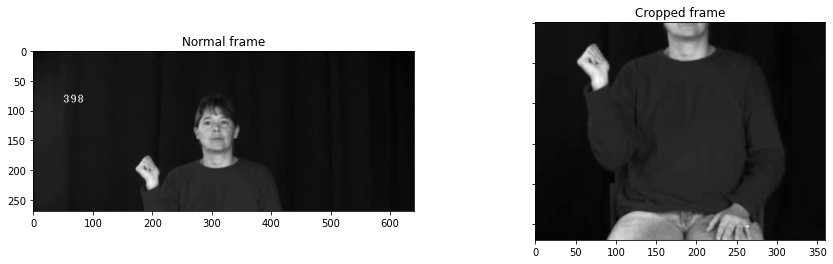

In [8]:
plot_image([img1, img2], cmap='gray', captions=["Normal frame", "Cropped frame"])

# Preprocessing the data

In [47]:
x_train = []
y_train = []
maxi = 0
mini = 200
def build_dics():
    maxi = -1
    mini = 200
    directory = "csvFiles/splitted/"
    for filename in os.listdir(directory):
        if ((filename == "Liz.CSV" or filename == "Tyler.CSV" or filename == "Naomi.CSV" or filename == "Lana.CSV" or filename == "Dana.CSV")):
            print("okay")
            temp = directory + filename
            print(temp)
            data = pd.read_csv(temp, header = None)
            signGloss = data[2]
            sessions = data[4]
            scene = data[5]
            mov = data[7]
            glossStart = data[8]
            glossEnd = data[9]
            for i in range(2,100):
                    cap = cv2.VideoCapture(mov[i])
                    firstFrame = int(glossStart[i])
                    endFrame = int(glossEnd[i])+1
                    
                    temp_frames = []
                    if(endFrame - firstFrame >= 20):
                        maxi = max(maxi, endFrame - firstFrame)
                        mini = min(mini, endFrame - firstFrame)
                        while(firstFrame != endFrame):
                            cap.set(1,firstFrame-1)  # Where frame_no is the frame you want
                            ret, frame = cap.read()  # Read the frame
                            if(ret):
                                img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                img = crop_center_square(img)
                                temp_frames.append(img)
                            firstFrame += 1

                        x_train.append(temp_frames)
                        y_train.append(signGloss[i])
    return maxi, mini
maxi,mini = build_dics()   

okay
csvFiles/splitted/Liz.CSV
okay
csvFiles/splitted/Naomi.CSV
okay
csvFiles/splitted/Lana.CSV
okay
csvFiles/splitted/Tyler.CSV
okay
csvFiles/splitted/Dana.CSV


In [48]:
print("max frames: ", maxi)
print("mini frames: ", mini)

max frames:  128
mini frames:  20


In [49]:
test = x_train

In [50]:
test[0] = test[0] + [[[0]*480]*480] *(maxi - len(test[0]))

In [51]:
len(test[0])

128

In [52]:
#[[[0.0]*480]*480] * (maxi - len(x_train[i]))

In [53]:
for i in range(len(x_train)):
    x_train[i] = x_train[i][:20]

In [54]:
dictionary = {}
for i in range(len(y_train)):
    if(x_train[i] != []):
        if (y_train[i] in dictionary.keys()):
            dictionary[y_train[i]].append(x_train[i])
        else:
            dictionary[y_train[i]] = [x_train[i]]

In [55]:
videos = []
labels = []
for i in dictionary.keys():
    if len(dictionary[i]) > 1:
        for j in dictionary[i]:
            labels.append(i)
            videos.append(j)

In [56]:
videos = np.array(videos)
labels = np.array(labels)

In [57]:
videos.shape

(112, 20, 270, 360)

In [58]:
videos.resize(videos.shape[0] * videos.shape[1], 270, 360)

In [59]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels.shape

(112, 54)

In [60]:
labels_ext = []
for i in labels:
    labels_ext += [i]*20

In [61]:
labels_ext = np.array(labels_ext)

In [62]:
labels_ext.shape

(2240, 54)

In [63]:
trainX, validX, trainY, validY = train_test_split(videos,labels_ext, test_size=0.25, train_size=None, random_state=None, shuffle=True, stratify=None)

In [64]:
trainX, testX, trainY, testY = train_test_split(videos,labels_ext, test_size=0.2, train_size=None, random_state=None, shuffle=True, stratify=None)

# Building the CNN model
 - A helper model that would operate on each frame seperately

In [65]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D, Dense
def build_convnet(shape=(WIDTH, HEIGHT, 1)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    model.add(Dense(labels.shape[1], activation="softmax"))
    return model

In [66]:
model1 = build_convnet((HEIGHT, WIDTH, 1))

In [67]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 270, 360, 64)      640       
                                                                 
 conv2d_25 (Conv2D)          (None, 270, 360, 64)      36928     
                                                                 
 batch_normalization_12 (Bat  (None, 270, 360, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 135, 180, 64)     0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 135, 180, 128)     73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 135, 180, 128)    

In [68]:
print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1792, 270, 360)
(1792, 54)
(560, 270, 360)
(560, 54)
(448, 270, 360)
(448, 54)


In [69]:
model1.compile(optimizer="Adam", loss="CategoricalCrossentropy", metrics=["mse"])
model1.fit(
    trainX,trainY,
    validation_data = (validX, validY),
    verbose=1,
    epochs=20)

Epoch 1/20
56/56 [==============================] - 26s 455ms/step - loss: 7.0016 - mse: 0.0204 - val_loss: 4.0684 - val_mse: 0.0180
Epoch 2/20
56/56 [==============================] - 25s 452ms/step - loss: 3.3396 - mse: 0.0172 - val_loss: 3.1037 - val_mse: 0.0167
Epoch 3/20
56/56 [==============================] - 25s 453ms/step - loss: 2.5313 - mse: 0.0147 - val_loss: 2.0780 - val_mse: 0.0132
Epoch 4/20
56/56 [==============================] - 25s 454ms/step - loss: 1.4990 - mse: 0.0099 - val_loss: 1.7347 - val_mse: 0.0116
Epoch 5/20
56/56 [==============================] - 25s 453ms/step - loss: 1.1212 - mse: 0.0075 - val_loss: 1.5605 - val_mse: 0.0110
Epoch 6/20
56/56 [==============================] - 25s 453ms/step - loss: 0.7000 - mse: 0.0050 - val_loss: 0.7707 - val_mse: 0.0060
Epoch 7/20
56/56 [==============================] - 25s 454ms/step - loss: 0.5475 - mse: 0.0042 - val_loss: 0.4069 - val_mse: 0.0033
Epoch 8/20
56/56 [==============================] - 25s 453ms/step - 

In [70]:
model1.evaluate(
    x=testX,
    y=testY,
    batch_size=None,
    verbose=1
)

14/14 [==============================] - 2s 114ms/step - loss: 0.1910 - mse: 0.0013


[0.1909763514995575, 0.00128388951998204]

In [71]:
predictions = model1.predict(x=testX)

14/14 [==============================] - 2s 112ms/step


In [74]:
count = 0
true = 0
for i in range(len(predictions)):
    if(np.argmax(predictions[i]) == np.argmax(testY[i])):
        true+=1
        #print(np.argmax(predictions[i]))
    count +=1
print("accuracy is: ",true / count * 100, "%")


accuracy is:  95.3125 %


In [112]:
CNNresults = model1.predict(x=videos)


70/70 [==============================] - 8s 111ms/step


In [115]:
newTrain = []
for i in range(len(CNNresults)):
    newTrain.append(np.argmax(CNNresults[i]))


In [116]:
features = []
count = 0
for i in range(0,len(newTrain), 20):
    print( i , end = " ")
    count += 1
    features.append(newTrain[i:i+20])


0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000 2020 2040 2060 2080 2100 2120 2140 2160 2180 2200 2220 

20

In [117]:
features = np.array(features)

In [186]:
xTest

array([[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
        41, 41, 41, 41],
       [43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43],
       [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 36,
        46, 46, 46, 46],
       [47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47],
       [49, 49, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23],
       [35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35],
       [19, 17, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19],
       [51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7],
       [ 0,  0,  0,  0,  0,  0

In [173]:
xTrain, xValid, yTrain, yValid = train_test_split(features,labels, test_size=0.25, train_size=None, random_state=None, shuffle=True, stratify=None)

In [174]:
xTrain, xTest, yTrain, yTest = train_test_split(features,labels, test_size=0.25, train_size=None, random_state=None, shuffle=True, stratify=None)

In [175]:
print(xTrain.shape)
print(xTest.shape)
print(xValid.shape)
print(yTrain.shape)
print(yTest.shape)
print(yValid.shape)

(84, 20)
(28, 20)
(28, 20)
(84, 54)
(28, 54)
(28, 54)


In [213]:
embed_dim = 60  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 20
inp = Input(shape=(maxlen,))
x = Embedding(20, embed_dim)(inp)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(labels.shape[1], activation="sigmoid")(x)
lstm = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(learning_rate=0.001)
lstm.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])

print(lstm.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 20)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 20, 60)            1200      
                                                                 
 bidirectional_34 (Bidirecti  (None, 20, 512)          649216    
 onal)                                                           
                                                                 
 bidirectional_35 (Bidirecti  (None, 20, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_36 (Bidirecti  (None, 20, 128)          164352    
 onal)                                                           
                                                           

In [214]:
lstm.fit(xTrain, yTrain, batch_size=50, epochs=80, validation_data=(xValid, yValid))

Epoch 1/80
2/2 [==============================] - 10s 2s/step - loss: 3.9873 - accuracy: 0.0476 - val_loss: 3.9743 - val_accuracy: 0.1786
Epoch 2/80
2/2 [==============================] - 0s 40ms/step - loss: 3.9728 - accuracy: 0.1429 - val_loss: 3.9553 - val_accuracy: 0.2500
Epoch 3/80
2/2 [==============================] - 0s 40ms/step - loss: 3.9482 - accuracy: 0.2738 - val_loss: 3.9255 - val_accuracy: 0.1786
Epoch 4/80
2/2 [==============================] - 0s 39ms/step - loss: 3.9190 - accuracy: 0.2500 - val_loss: 3.8774 - val_accuracy: 0.1786
Epoch 5/80
2/2 [==============================] - 0s 47ms/step - loss: 3.8540 - accuracy: 0.2262 - val_loss: 3.8095 - val_accuracy: 0.1429
Epoch 6/80
2/2 [==============================] - 0s 43ms/step - loss: 3.7807 - accuracy: 0.2024 - val_loss: 3.7374 - val_accuracy: 0.1786
Epoch 7/80
2/2 [==============================] - 0s 40ms/step - loss: 3.6932 - accuracy: 0.2024 - val_loss: 3.6710 - val_accuracy: 0.1429
Epoch 8/80
2/2 [============

In [215]:
pred = (lstm.predict(xTest))


1/1 [==============================] - 2s 2s/step


In [218]:
true = 0
count = 0
for i in range(len(pred)):
    #print(np.argmax(yTest[i]), end = " ")
    #print(np.argmax(pred[i]))
    if(np.argmax(pred[i]) == np.argmax(yTest[i])):
        true+=1
    count+=1
print("accuracy : ", true/count*100, "%")

accuracy :  32.142857142857146 %


# Building our main model
 - This model uses TimeDistributed layer which lets us pass a sequence of frames for one data point

In [19]:
def action_model(shape=(30, 480, 480, 1), nbout=labels.shape[1]):
    # Create our convnet with (224, 224, 1) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [20]:
INSHAPE=(7,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, labels.shape[1])
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 7, 512)           4688064   
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                110976    
                                                                 
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [26]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

In [27]:
valid = (validX, validY)

In [28]:
train = (trainX, trainY)

In [73]:
model.fit(
    trainX,trainY,
    verbose=1,
    epochs=5,
    callbacks=callbacks
)

NameError: name 'model' is not defined

In [ ]:
validX.shape

In [ ]:
validY.shape

In [ ]:
trainX.shape

In [ ]:
trainY.shape

In [31]:
x_train.shape

AttributeError: 'list' object has no attribute 'shape'